In [5]:
from torchsummary import summary
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=15)

summary(model, input_size=(3,128,128), device='cpu')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to C:\Users\kwon/.cache\torch\hub\checkpoints\efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [24:50<00:00, 179kB/s]  


Loaded pretrained weights for efficientnet-b7
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 129, 129]               0
Conv2dStaticSamePadding-2           [-1, 64, 64, 64]           1,728
       BatchNorm2d-3           [-1, 64, 64, 64]             128
MemoryEfficientSwish-4           [-1, 64, 64, 64]               0
         ZeroPad2d-5           [-1, 64, 66, 66]               0
Conv2dStaticSamePadding-6           [-1, 64, 64, 64]             576
       BatchNorm2d-7           [-1, 64, 64, 64]             128
MemoryEfficientSwish-8           [-1, 64, 64, 64]               0
          Identity-9             [-1, 64, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 16, 1, 1]           1,040
MemoryEfficientSwish-11             [-1, 16, 1, 1]               0
         Identity-12             [-1, 16, 1, 1]               0
Conv2dStaticSamePadding-13        

In [1]:
import os
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import time
import copy

from torch.optim import lr_scheduler
from torchvision import datasets
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
from torch.utils.tensorboard import SummaryWriter

In [13]:
batch_size = 150
epochs = 20
writer = SummaryWriter('./runs/experiment1/')

In [14]:
meanR, meanG, meanB = 0.5602434, 0.5241528, 0.5015032
stdR, stdG, stdB = 0.2273327, 0.23729324, 0.24018635

In [15]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize([128, 86]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
    ]),
    'test': transforms.Compose([transforms.Resize([128, 86]),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
    ])
}

In [16]:
data_dir = './splitted' 
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'test']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=18)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

since = time.time()

best_model_weights = copy.deepcopy(model.state_dict())
best_acc = 0.0

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /opt/ml/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


In [9]:
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()

        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        # writer.add_graph('epoch loss', epoch_loss, epoch)
        # writer.add_graph('epoch acc', epoch_acc, epoch)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = copy.deepcopy(model.state_dict())

Epoch 0/19
----------
train Loss: 0.2644 Acc: 0.9164
test Loss: 2.1832 Acc: 0.7186
Epoch 1/19
----------
train Loss: 0.0570 Acc: 0.9827
test Loss: 2.3432 Acc: 0.7106
Epoch 2/19
----------
train Loss: 0.0347 Acc: 0.9900
test Loss: 1.4930 Acc: 0.7493
Epoch 3/19
----------
train Loss: 0.0344 Acc: 0.9901
test Loss: 1.5566 Acc: 0.7670
Epoch 4/19
----------
train Loss: 0.0246 Acc: 0.9929
test Loss: 1.5918 Acc: 0.7545
Epoch 5/19
----------
train Loss: 0.0235 Acc: 0.9935
test Loss: 1.9093 Acc: 0.7307
Epoch 6/19
----------
train Loss: 0.0215 Acc: 0.9943
test Loss: 1.6851 Acc: 0.7541
Epoch 7/19
----------
train Loss: 0.0038 Acc: 0.9990
test Loss: 1.4573 Acc: 0.8157
Epoch 8/19
----------
train Loss: 0.0012 Acc: 0.9997
test Loss: 1.4968 Acc: 0.8186
Epoch 9/19
----------
train Loss: 0.0005 Acc: 0.9999
test Loss: 1.5772 Acc: 0.8183
Epoch 10/19
----------
train Loss: 0.0006 Acc: 0.9999
test Loss: 1.5959 Acc: 0.8187
Epoch 11/19
----------
train Loss: 0.0004 Acc: 0.9999
test Loss: 1.6480 Acc: 0.8189
Ep

In [10]:
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Training complete in 102m 13s
Best val Acc: 0.822860


In [11]:
torch.save(best_model_weights, './best_weights_b7_class_18.pth')

In [17]:
model.load_state_dict(torch.load("./best_weights_b7_class_18.pth"))
model.eval()

correct = 0
wrong = 0
test_predictions = []
all_labels = []
for images, label in dataloaders["test"]:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        _, pred = torch.max(pred, 1) 
        test_predictions.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

for i in range(len(test_predictions)):
    if test_predictions[i] == all_labels[i]:
        correct += 1
    else:
        wrong += 1

print(correct)
print(wrong)

2480
292


In [19]:
print(correct / (correct + wrong))

0.8946608946608947


In [20]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import Resize, ToTensor, Normalize, transforms
from torchvision.datasets import ImageFolder
import shutil
import torch.optim as optim
from zlib import crc32
import time
import copy
 

In [21]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [22]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
check_dir = './input/data/eval'

In [26]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(check_dir, 'info.csv'))
image_dir = os.path.join(check_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform_test = transforms.Compose([
    transforms.Resize([170, 128]),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])

dataset_test = TestDataset(image_paths, transform_test)

loader_test = DataLoader(
    dataset_test,
    shuffle=False
)
    
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)

model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=18)
model.load_state_dict(torch.load("./best_weights_b7_class_18.pth"))
model.to(device)
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader_test:
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        _, pred = torch.max(pred, 1) 
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(check_dir, 'submission.csv'), index=False)
print('inference is done!')

Loaded pretrained weights for efficientnet-b7
inference is done!


In [37]:
check_dir

'./input/data/eval'

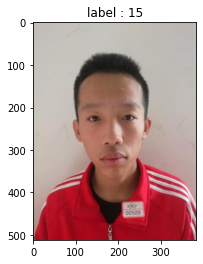

In [36]:
import matplotlib.pyplot as plt
import matplotlib.image as img

index = np.random.randint(0, len(image_paths))
image = img.imread(image_paths[index])
plt.title("label : %s" % all_predictions[index])
plt.imshow(image)
plt.show()